<a href="https://colab.research.google.com/github/heriswaya/MLT-Project-1-and-2/blob/main/forecasting_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**

### **Latar Belakang**
Dalam industri ritel, prediksi permintaan (demand forecasting) merupakan komponen krusial dalam pengambilan keputusan bisnis. Dengan meningkatnya kompleksitas faktor yang memengaruhi permintaan seperti musim, promosi, harga kompetitor, hingga kondisi eksternal seperti pandemi, diperlukan pendekatan berbasis data yang andal dan adaptif.

**Time Series Forecasting** adalah pendekatan yang tepat untuk memahami pola permintaan produk dari waktu ke waktu dan memprediksi tren ke depan. Dengan memahami perilaku permintaan harian, perusahaan dapat merencanakan pengadaan barang, promosi, serta strategi logistik yang lebih efisien.

### **Tujuan Proyek**
Proyek ini bertujuan untuk membangun model **Time Series Forecasting** guna memprediksi permintaan harian (`Demand`) untuk produk tertentu dalam sebuah toko ritel. Pendekatan ini akan membantu dalam memahami pola permintaan berdasarkan data historis serta faktor eksternal seperti cuaca, promosi, dan pandemi.

### **Tentang Dataset**
Dataset ini merupakan hasil modifikasi dari *Retail Store Inventory Forecasting Dataset*. Versi ini telah dikoreksi dari kesalahan ID dan ditambahkan fitur `Epidemic` untuk mensimulasikan kondisi pandemi seperti COVID-19. Dataset ini sangat relevan untuk eksperimen time series karena mencakup fitur-fitur penting:

- Tanggal transaksi (`Date`)
- Informasi produk dan toko
- Tingkat inventaris dan unit terjual
- Faktor eksternal: cuaca, musim, promosi, dan pandemi
- Target: **Demand** harian

## **Import Library**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## **Load Dataset**

In [81]:
# URL file CSV dari GitHub heriswaya (ubah menjadi link raw)
url = 'https://raw.githubusercontent.com/heriswaya/MLT-Project-1-and-2/main/sales_data.csv'

# Load dataset
df = pd.read_csv(url)

# Tampilkan 5 baris pertama
df.head()

Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001  Electronics  North              195   
1  2022-01-01     S001      P0002     Clothing  North              117   
2  2022-01-01     S001      P0003     Clothing  North              247   
3  2022-01-01     S001      P0004  Electronics  North              139   
4  2022-01-01     S001      P0005    Groceries  North              152   

   Units Sold  Units Ordered  Price  Discount Weather Condition  Promotion  \
0         102            252  72.72         5             Snowy          0   
1         117            249  80.16        15             Snowy          1   
2         114            612  62.94        10             Snowy          1   
3          45            102  87.63        10             Snowy          0   
4          65            271  54.41         0             Snowy          0   

   Competitor Pricing Seasonality  Epidemic  Demand  
0               85.73      Winter         0     115  
1               92.02      Winter         0     229  
2               60.08      Winter         0     157  
3               85.19      Winter         0      52  
4               51.63      Winter         0      59

## **Exploratory Data Analysis (EDA)**

### Description Variabel

In [82]:
# Tampilkan info awal
print("Informasi Dataset:")
df.info()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null

In [83]:
# Konversi kolom 'Date' ke datetime
df['Date'] = pd.to_datetime(df['Date'])

# Statistik deskriptif
print("\nDeskripsi Statistik:")
print(df.describe())


Deskripsi Statistik:
                      Date  Inventory Level    Units Sold  Units Ordered  \
count                76000     76000.000000  76000.000000   76000.000000   
mean   2023-01-15 12:00:00       301.062842     88.827316      89.090645   
min    2022-01-01 00:00:00         0.000000      0.000000       0.000000   
25%    2022-07-09 18:00:00       136.000000     58.000000       0.000000   
50%    2023-01-15 12:00:00       227.000000     84.000000       0.000000   
75%    2023-07-24 06:00:00       408.000000    114.000000     121.000000   
max    2024-01-30 00:00:00      2267.000000    426.000000    1616.000000   
std                    NaN       226.510161     43.994525     162.404627   

              Price      Discount     Promotion  Competitor Pricing  \
count  76000.000000  76000.000000  76000.000000        76000.000000   
mean      67.726028      9.087039      0.328947           69.454029   
min        4.740000      0.000000      0.000000            4.290000   
25%      

### Check Missing Value

In [84]:
# Cek missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Price                 0
Discount              0
Weather Condition     0
Promotion             0
Competitor Pricing    0
Seasonality           0
Epidemic              0
Demand                0
dtype: int64


Terlihat bahwa data yang digunakan itu tidak ada missing value, sehingga tidak perlu ada perlakuan dalam bagian ini.

### Check Outliers

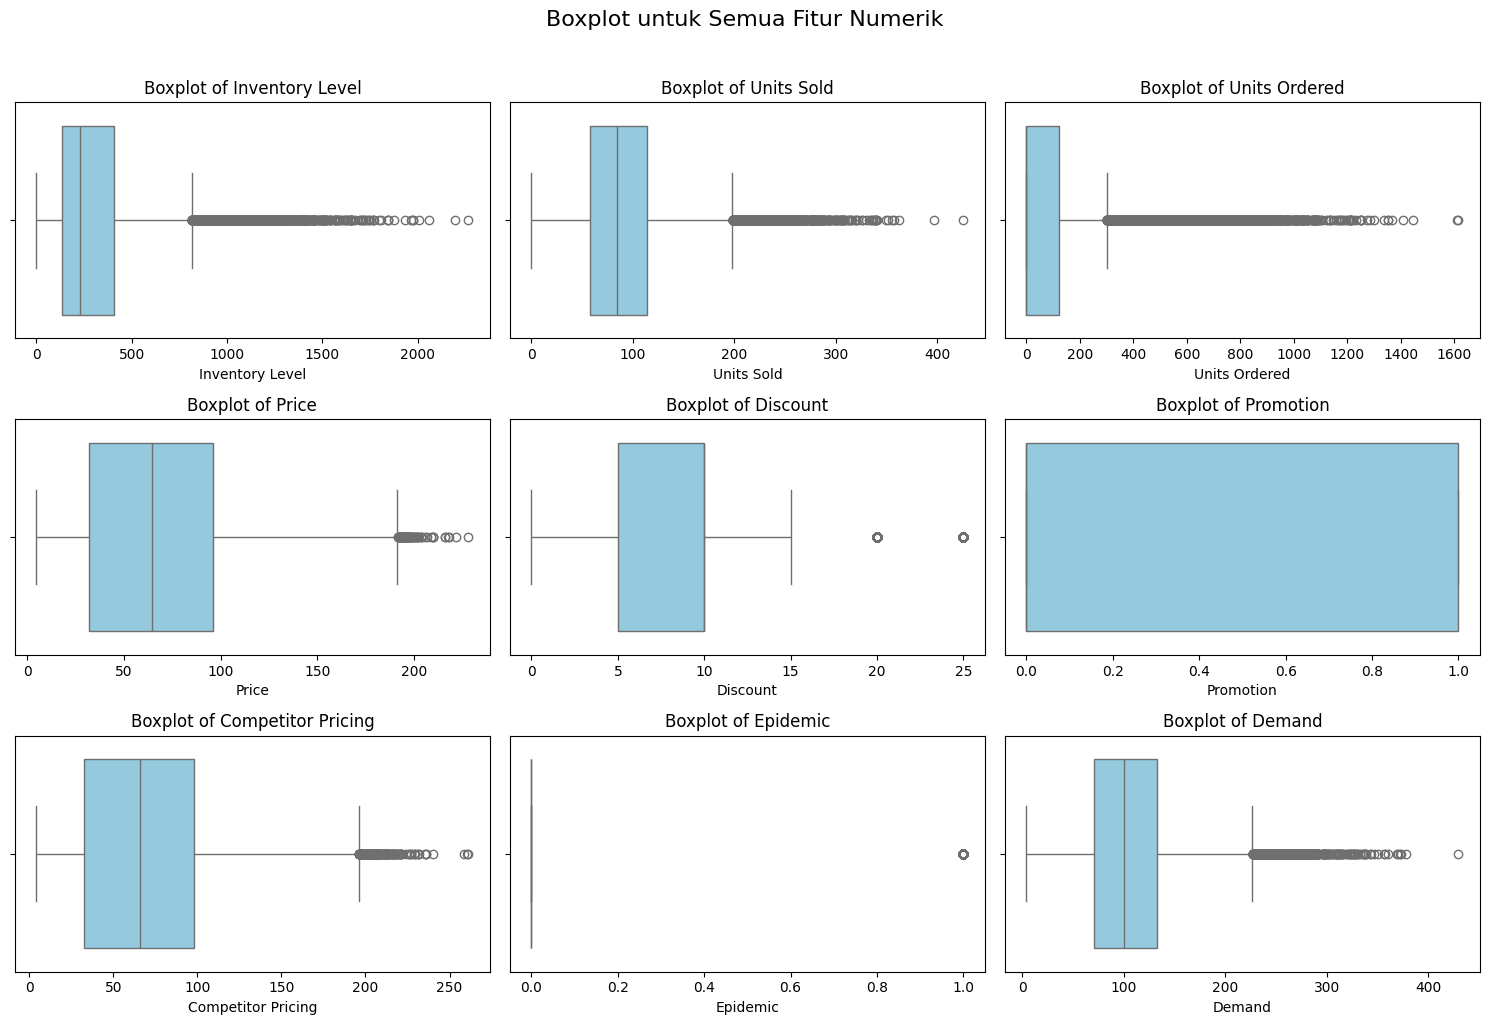

In [85]:
# Pilih hanya kolom numerik
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Buat boxplot untuk setiap fitur numerik
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.suptitle('Boxplot untuk Semua Fitur Numerik', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Berdasarkan hasil visualisasi boxplot terhadap seluruh fitur numerik, terlihat bahwa **hampir semua fitur memiliki outlier**, terutama pada kolom:

* `Inventory Level`
* `Units Sold`
* `Units Ordered`
* `Price`
* `Competitor Pricing`
* `Demand`

Sementara itu, kolom seperti `Discount` memiliki beberapa nilai ekstrem, namun jumlahnya tidak terlalu signifikan. Kolom `Promotion` dan `Epidemic` tidak menunjukkan outlier karena merupakan fitur biner (0/1).

### ✦ Apakah Perlu Ditangani?

Karena proyek ini bertujuan untuk **forecasting time series**, maka pendekatan terhadap outlier berbeda dengan model supervised learning biasa:

* **Tidak semua outlier harus dihapus atau ditangani secara agresif.**
* Dalam konteks forecasting, outlier dapat merepresentasikan **kejadian musiman, promosi besar-besaran, atau kondisi khusus seperti pandemi (COVID-19)**.
* Misalnya, lonjakan `Units Ordered` bisa saja terjadi karena promosi besar (lihat juga fitur `Promotion`) atau pengaruh `Epidemic`.

### ✦ Keputusan:

> **Outlier tidak akan dihapus pada tahap ini**, karena:

1. Mereka bisa mengandung **informasi penting terkait tren musiman atau siklus bisnis**.
2. Data ini digunakan untuk *time series forecasting*, di mana menjaga kontinuitas dan keutuhan data historis sangat krusial.
3. Outlier yang benar-benar anomali akan lebih baik ditangani pada tahap **residual analysis** setelah pemodelan, atau dengan metode robust saat pemodelan.

---

### Univariate Analysis

In [86]:
# Pisahkan fitur numerik dan kategorikal
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Fitur Numerik:", numerical_features)
print("Fitur Kategorikal:", categorical_features)

Fitur Numerik: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic', 'Demand']
Fitur Kategorikal: ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']


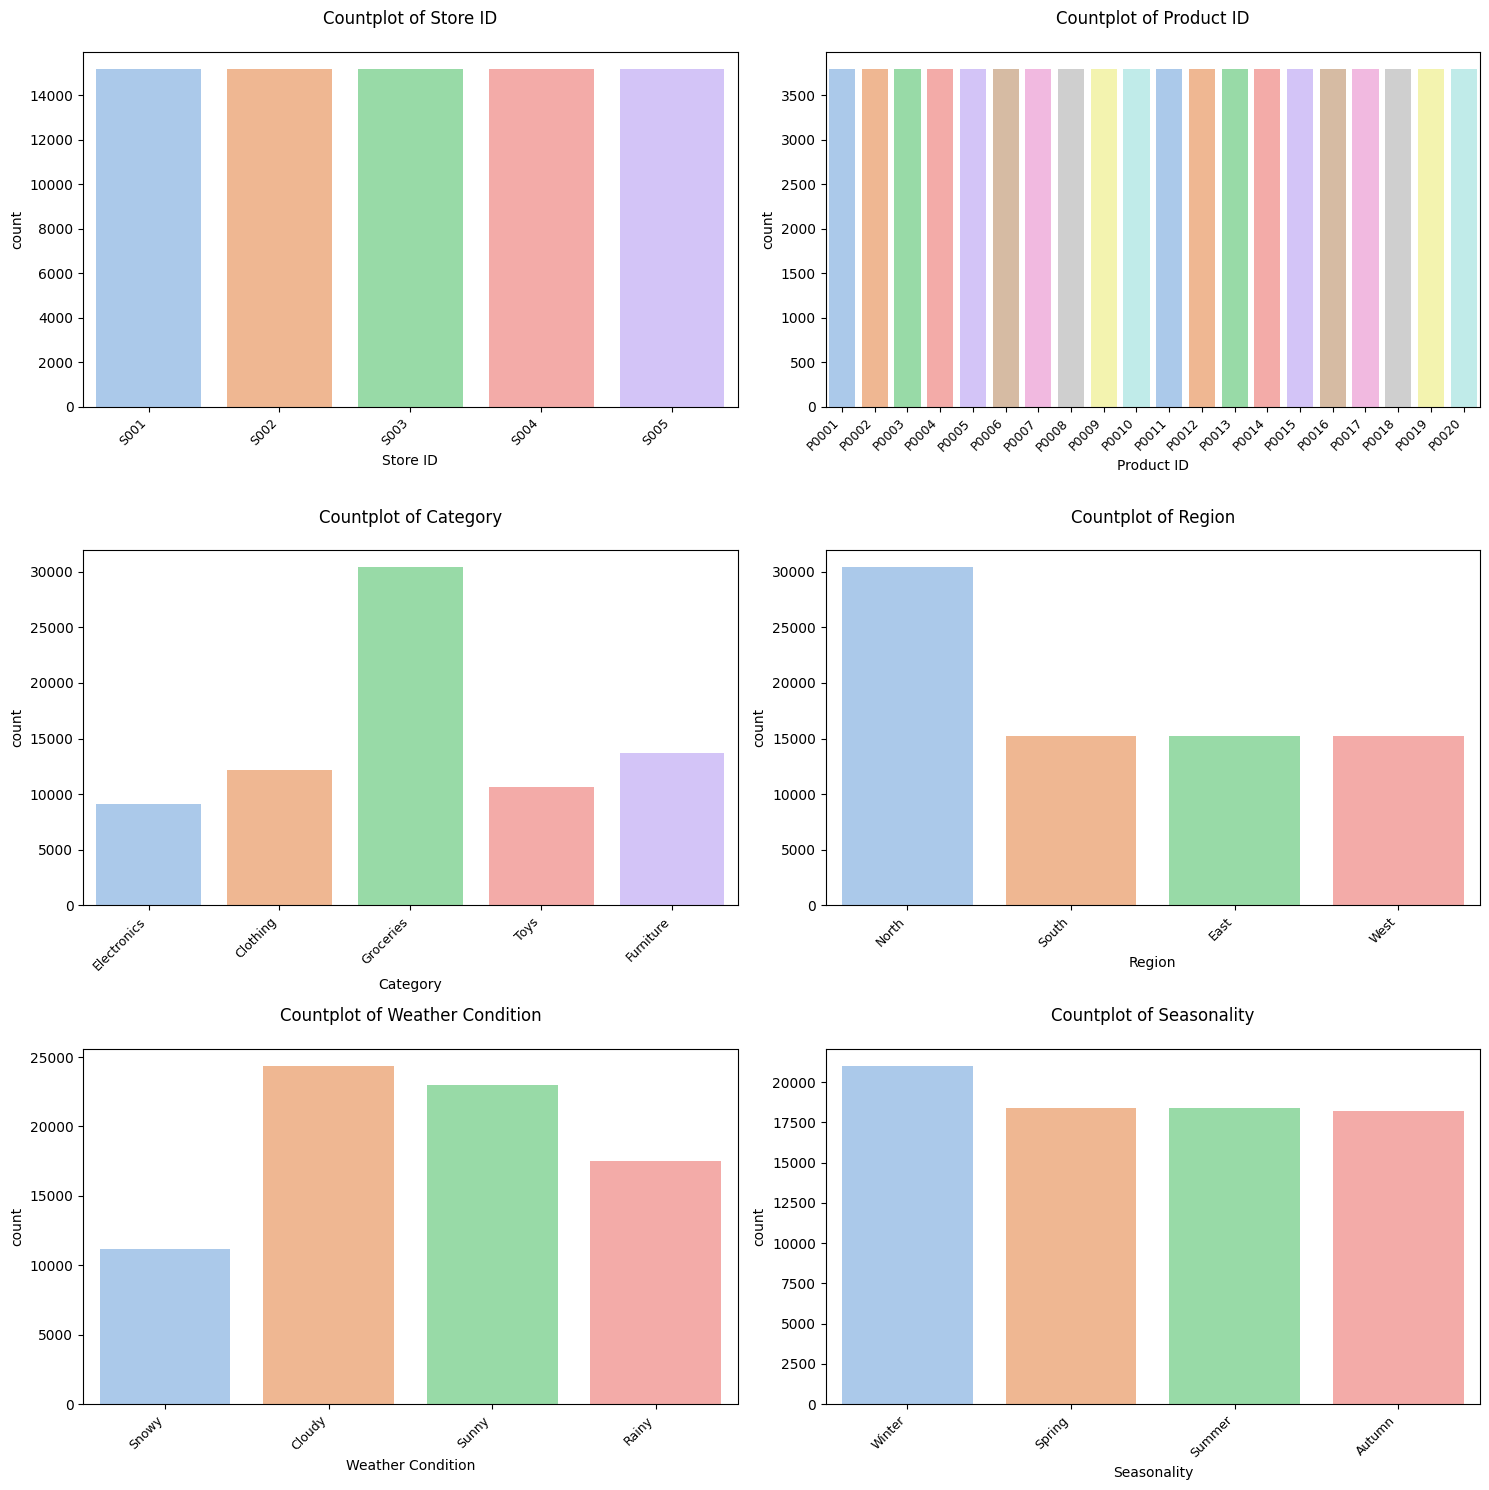

In [87]:
# Visualisasi fitur kategorikal
# Hitung jumlah fitur kategorikal
n_cat = len(categorical_features)
cols = 2  # Jumlah kolom yang diinginkan
rows = (n_cat + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# Buat figure dengan ukuran yang lebih besar
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Atur spacing antar subplot
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten axes jika lebih dari 1 baris
if rows > 1:
    axes = axes.flatten()

# Plot setiap fitur kategorikal
for i, col in enumerate(categorical_features):
    # Buat plot
    sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])

    # Atur title dengan padding
    axes[i].set_title(f'Countplot of {col}', pad=20)

    # Rotasi label x-axis dan atur font size
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)

    # Atur layout untuk mencegah text overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(),
                           rotation=45,
                           ha='right',
                           fontsize=9)

# Sembunyikan axes yang tidak terpakai
for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

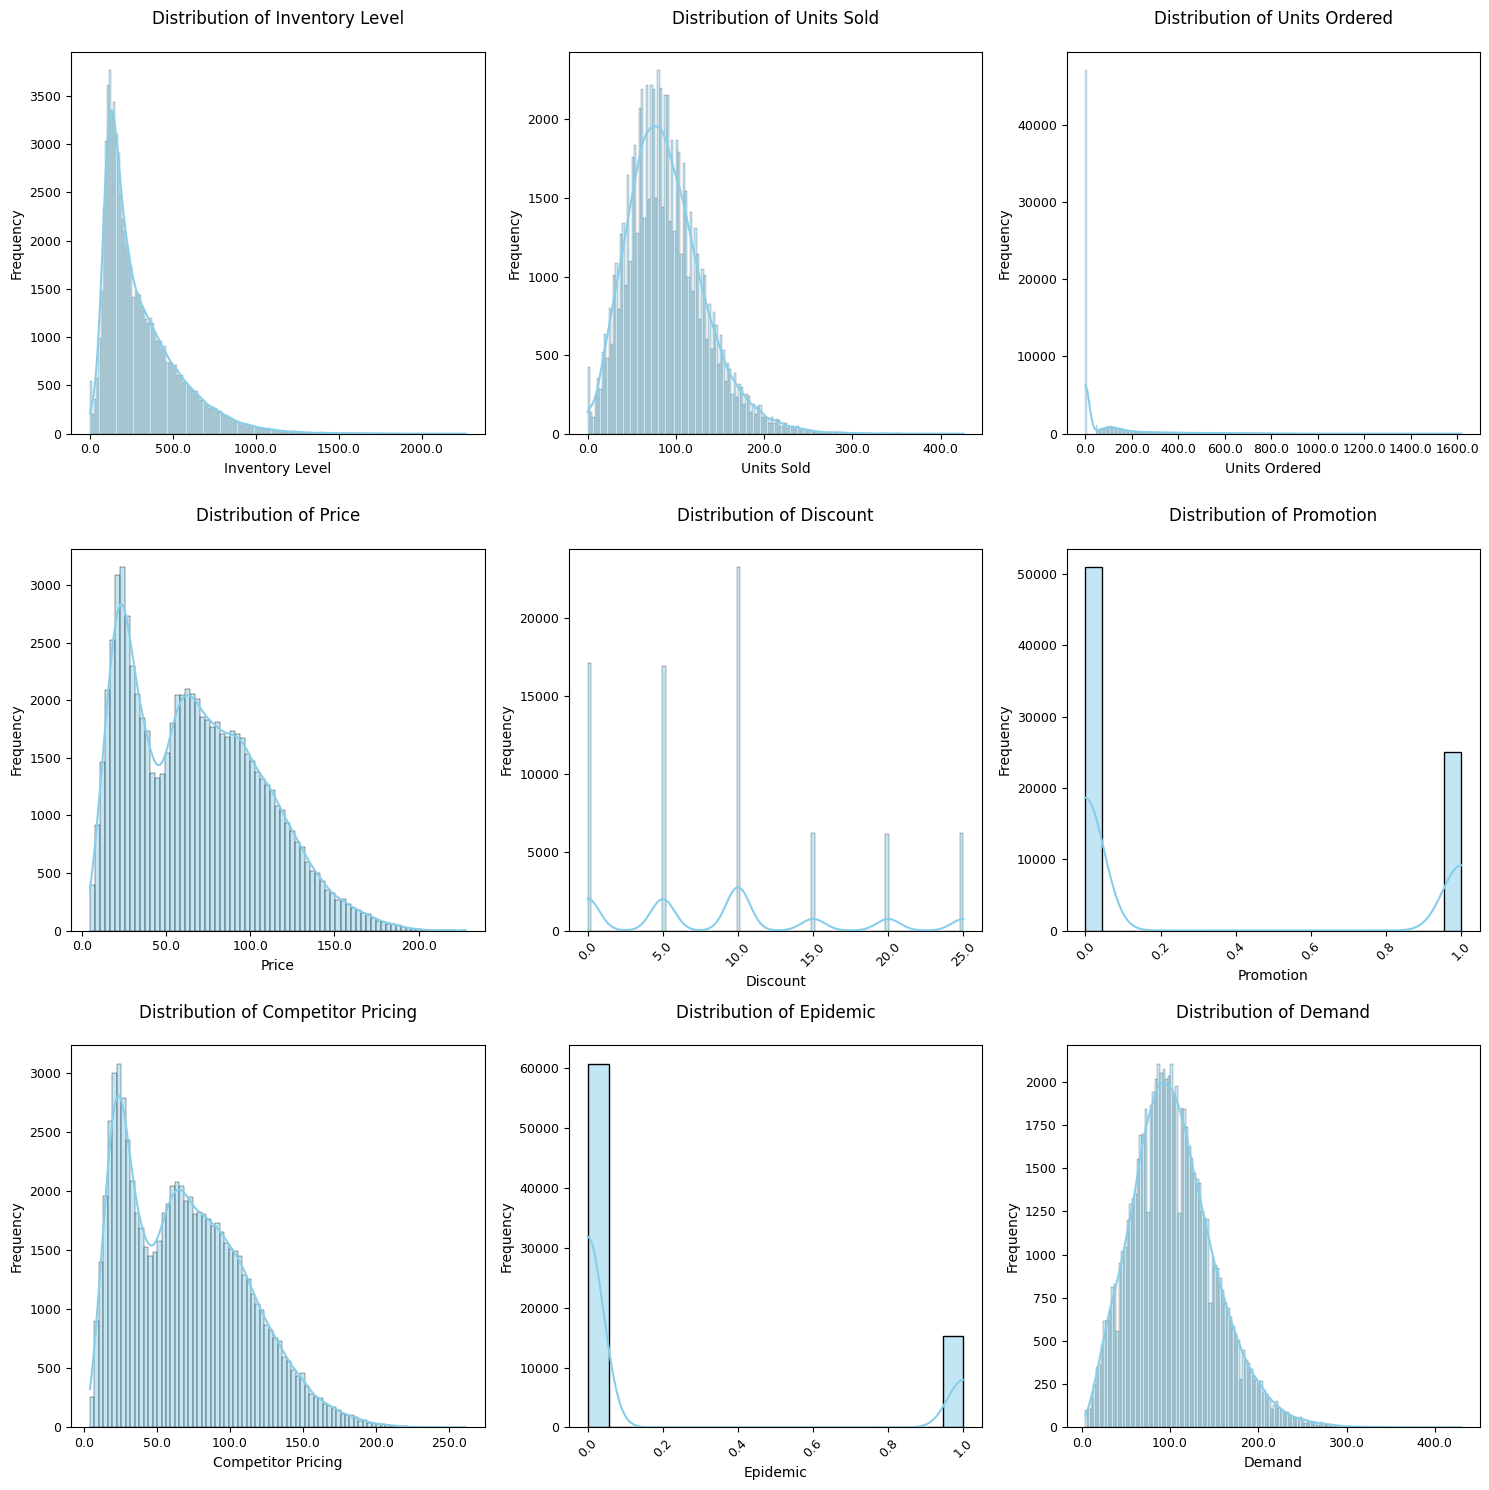

In [88]:
# Visualisasi Fitur Numerik
# Hitung jumlah fitur numerik
n_num = len(numerical_features)
cols = 3  # Jumlah kolom yang diinginkan
rows = (n_num + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# Buat figure dengan ukuran yang disesuaikan
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Atur spacing antar subplot
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten axes jika lebih dari 1 baris
if rows > 1:
    axes = axes.flatten()

# Plot setiap fitur numerik
for i, col in enumerate(numerical_features):
    # Buat histogram dengan KDE
    sns.histplot(df[col], kde=True, color='skyblue', ax=axes[i])

    # Atur title dengan padding
    axes[i].set_title(f'Distribution of {col}', pad=20, fontsize=12)

    # Atur label sumbu x
    axes[i].set_xlabel(col, fontsize=10)

    # Atur label sumbu y
    axes[i].set_ylabel('Frequency', fontsize=10)

    # Atur tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=9)

    # Format angka pada sumbu jika perlu
    axes[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

    # Rotasi label x jika diperlukan
    if len(df[col].unique()) < 10:  # Jika data diskrit
        axes[i].tick_params(axis='x', rotation=45)

# Sembunyikan axes yang tidak terpakai
for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Univariate analysis bertujuan untuk melihat distribusi masing-masing fitur secara individu.

- Untuk **fitur kategorikal**, digunakan *countplot* untuk melihat frekuensi masing-masing kategori.
- Untuk **fitur numerik**, digunakan *histogram* untuk melihat sebaran nilai, apakah normal, skewed, atau multimodal.

Hasil analisis ini penting untuk memahami karakteristik dasar tiap fitur sebelum dilakukan pemodelan lebih lanjut.


### Multivariate Analysis

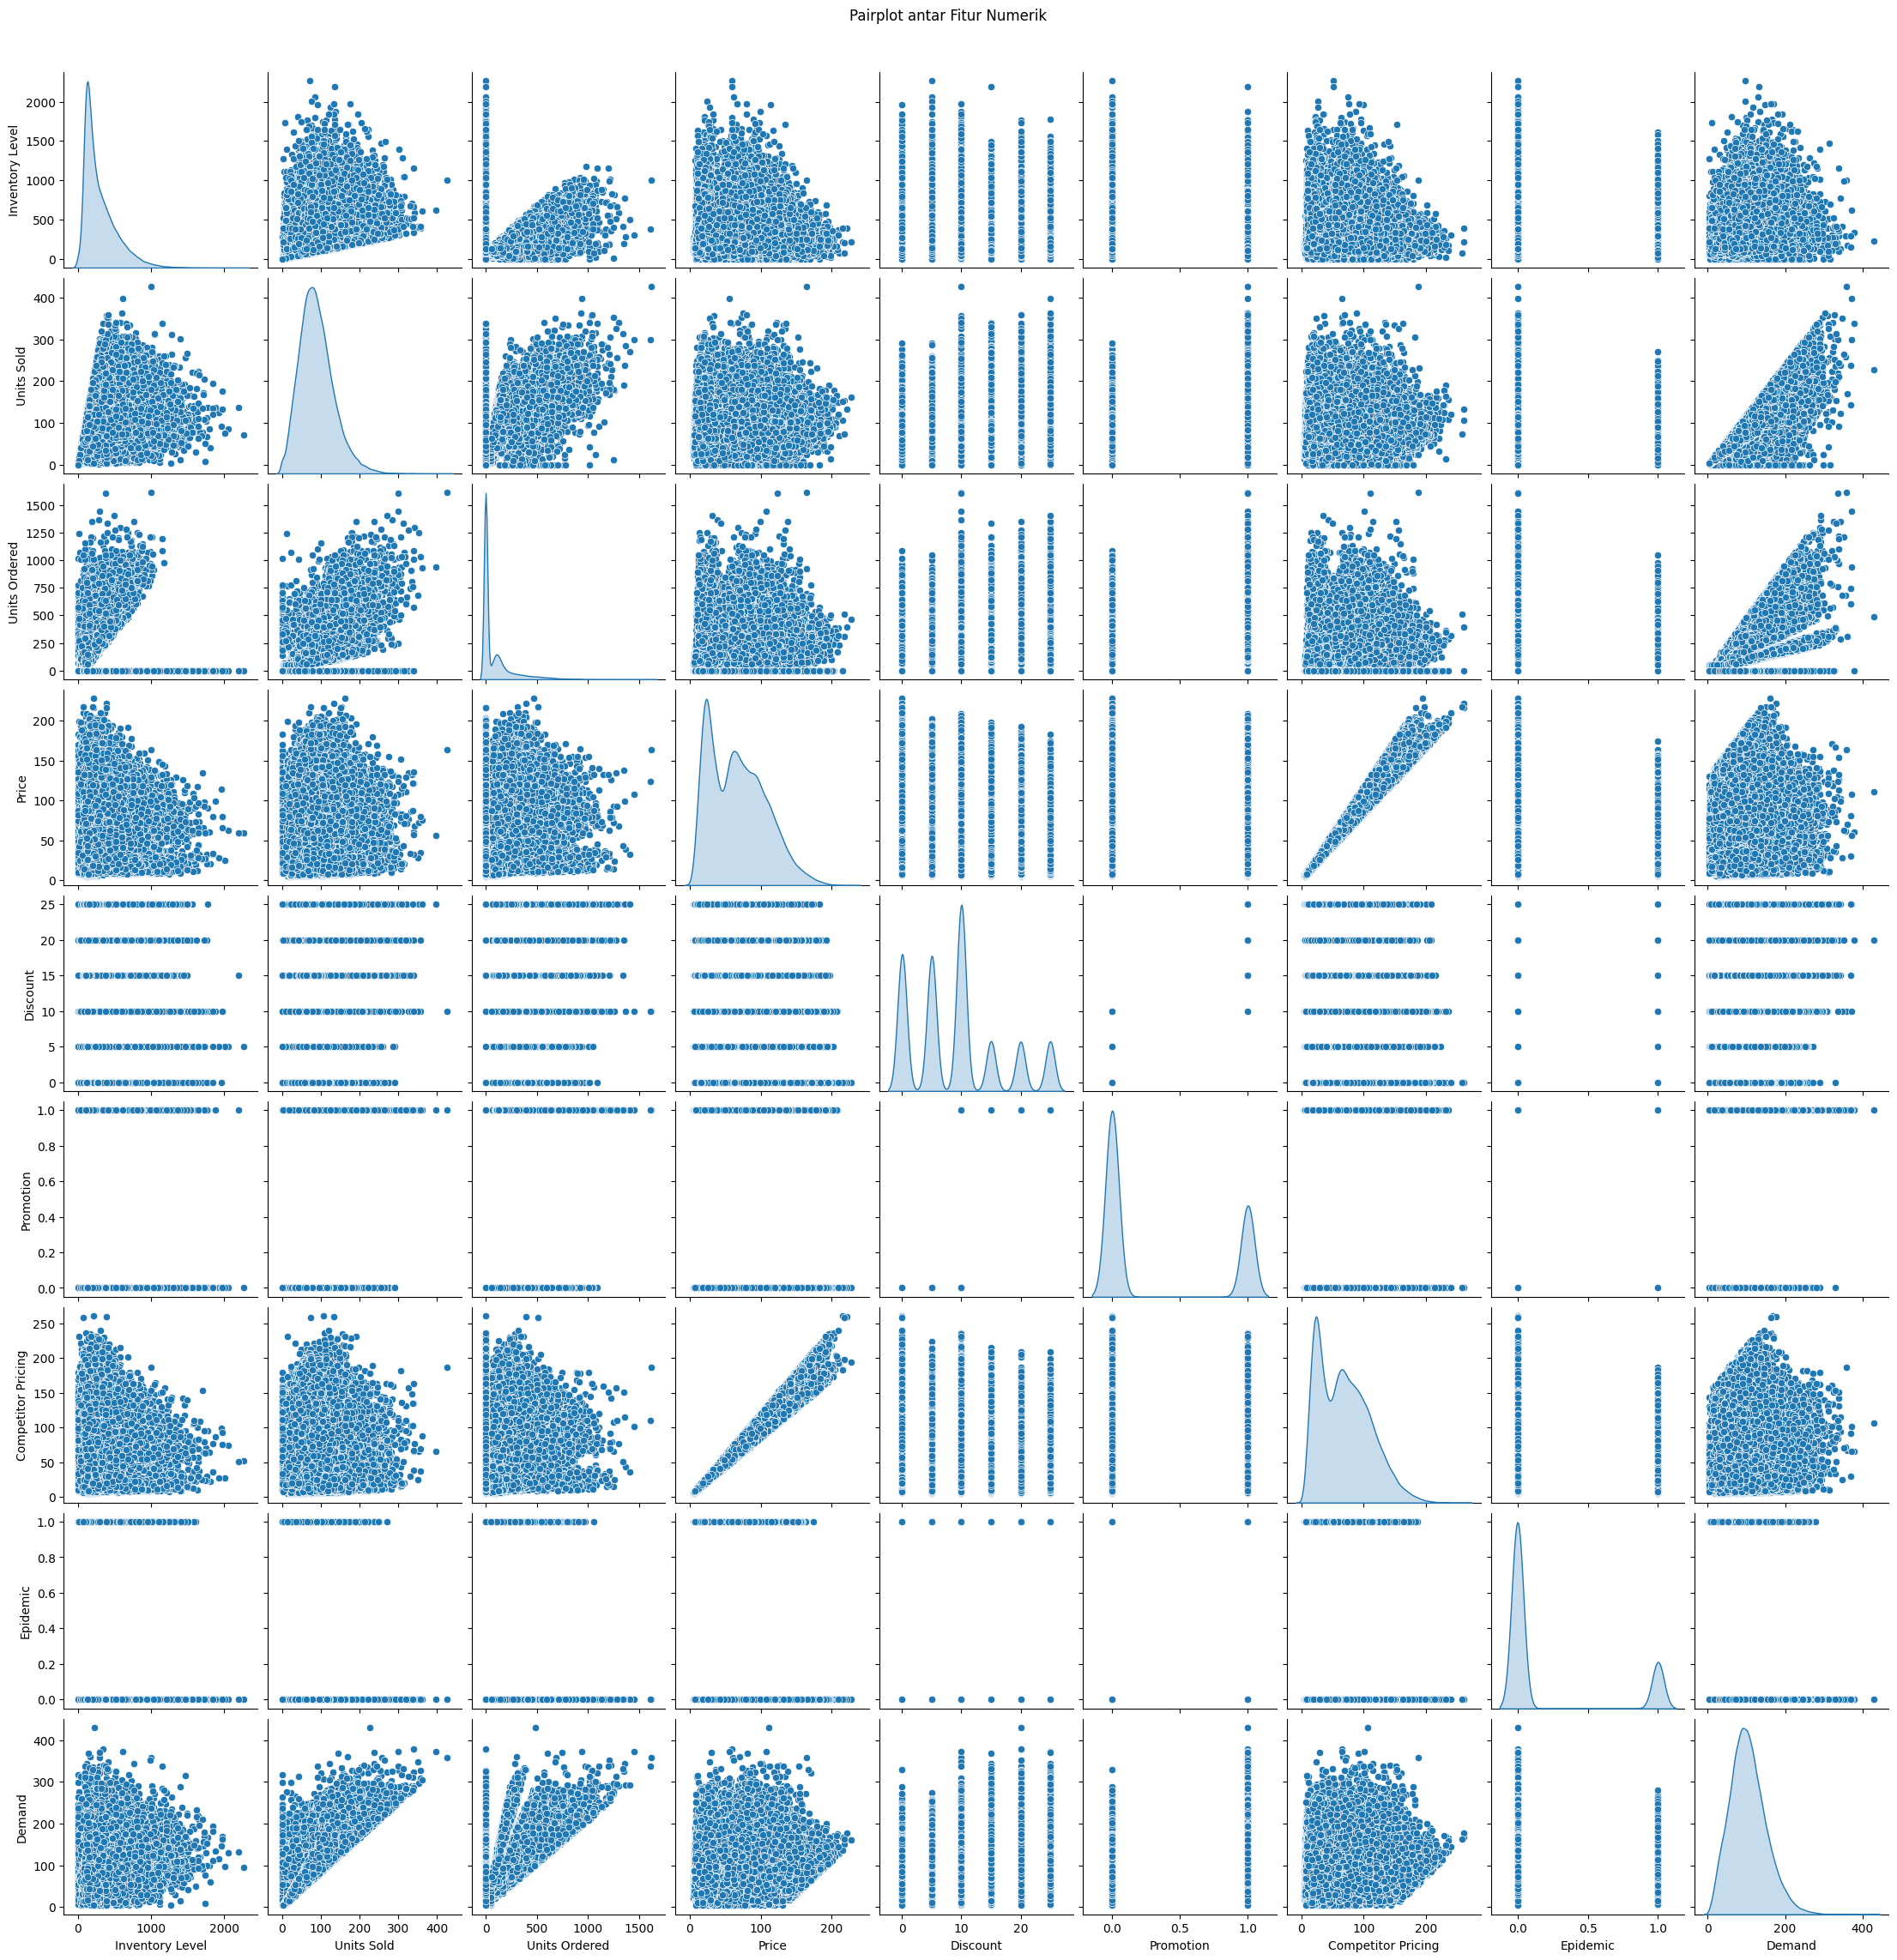

In [89]:
# Pairplot antar fitur numerik untuk melihat hubungan dan distribusi
sns.pairplot(df[numerical_features], diag_kind='kde')
plt.suptitle('Pairplot antar Fitur Numerik', y=1.02)
plt.show()

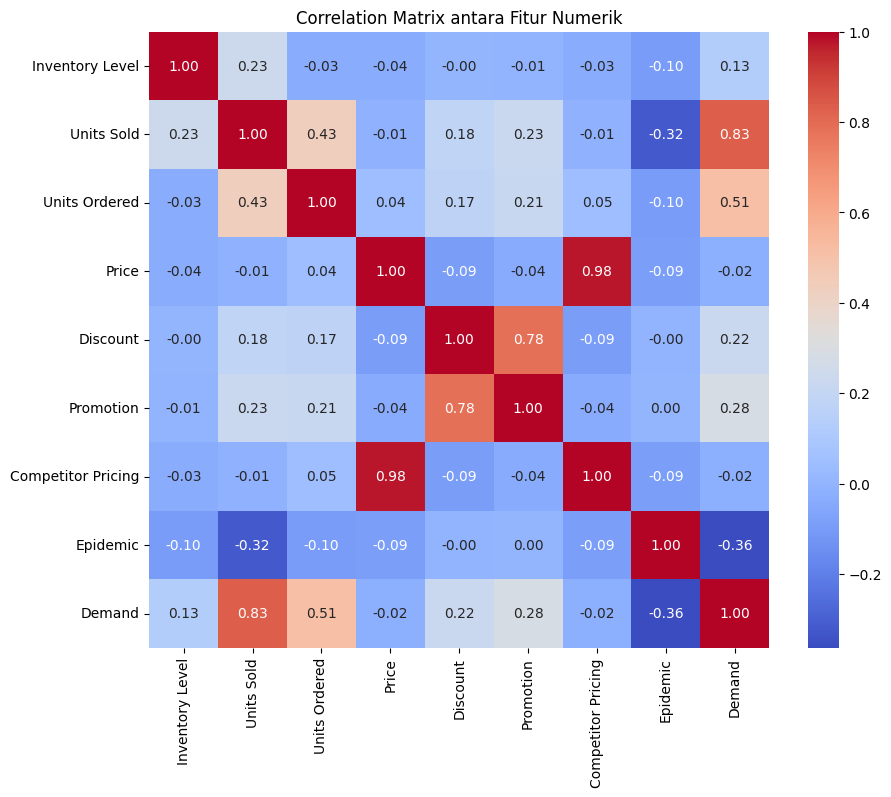

In [90]:
# Korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix antara Fitur Numerik')
plt.show()

Untuk melihat hubungan antar fitur numerik sekaligus dalam satu visualisasi yang komprehensif, digunakan `pairplot`.

- Pairplot menunjukkan scatterplot untuk setiap pasangan fitur.
- Bagian diagonal menampilkan distribusi dari masing-masing fitur (menggunakan KDE).
- Korelasi visual antara fitur dan target `Demand` dapat dilihat secara langsung dari pola sebarannya.
- **Heatmap korelasi** digunakan untuk melihat hubungan linear antar fitur numerik.

Analisis ini membantu mengidentifikasi fitur-fitur dengan pengaruh kuat terhadap permintaan (demand), yang sangat penting dalam model prediksi.


## **Data Preparation**

In [91]:
# Urutkan data berdasarkan tanggal
df = df.sort_values('Date')

# Tampilkan 5 baris teratas untuk memastikan perubahan
df.head()

Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001  Electronics  North              195   
72 2022-01-01     S004      P0013    Groceries   West              136   
71 2022-01-01     S004      P0012  Electronics   West              111   
70 2022-01-01     S004      P0011     Clothing   West              195   
69 2022-01-01     S004      P0010    Groceries   West              223   

    Units Sold  Units Ordered   Price  Discount Weather Condition  Promotion  \
0          102            252   72.72         5             Snowy          0   
72         104            385   20.24        10             Snowy          0   
71         111            113  118.15         0             Snowy          0   
70          60            293   52.89         0             Snowy          0   
69         120            597   30.02         0             Snowy          0   

    Competitor Pricing Seasonality  Epidemic  Demand  
0                85.73      Winter         0     115  
72               18.90      Winter         0     110  
71              133.46      Winter         0     103  
70               62.29      Winter         0      61  
69               29.15      Winter         0     128

In [92]:
# Cek tipe data untuk melihat apakah encoding diperlukan
df.dtypes

Date                  datetime64[ns]
Store ID                      object
Product ID                    object
Category                      object
Region                        object
Inventory Level                int64
Units Sold                     int64
Units Ordered                  int64
Price                        float64
Discount                       int64
Weather Condition             object
Promotion                      int64
Competitor Pricing           float64
Seasonality                   object
Epidemic                       int64
Demand                         int64
dtype: object

Untuk membuat model forecasting yang efisien dan tetap mencerminkan kompleksitas data, dipilih satu toko saja yaitu `S001` dengan kelima kategori produk:

- Electronics
- Clothing
- Groceries
- Toys
- Furniture

Pendekatan ini cukup untuk mengevaluasi performa model berdasarkan variasi kategori. Strategi ini juga bersifat scalable: jika ingin membuat model untuk toko lain, cukup ubah filter `Store ID`.

In [93]:
from sklearn.preprocessing import StandardScaler

# -------- 1) filter satu toko --------
selected_store = 'S001'
df_store = df[df['Store ID'] == selected_store].copy()

# -------- 2) list kategori & dict penampung --------
categories     = ['Electronics', 'Clothing', 'Groceries', 'Toys', 'Furniture']
category_dfs   = {}

for cat in categories:
    # ----- 2a) subset per kategori -----
    df_cat = df_store[df_store['Category'] == cat].copy()

    # ----- 3) drop kolom yang benar-benar tidak relevan -----
    df_cat.drop(columns=['Product ID', 'Store ID', 'Region'], inplace=True)

    # ----- 4) one-hot encoding weather & seasonality -----
    df_cat = pd.get_dummies(
        df_cat,
        columns=['Category','Weather Condition', 'Seasonality'],
        drop_first=True
    )

    # ----- 5) standarisasi numerik (selain Demand) -----
    num_cols = df_cat.drop(columns=['Demand']).select_dtypes(['int64', 'float64']).columns
    scaler   = StandardScaler()
    df_cat[num_cols] = scaler.fit_transform(df_cat[num_cols])

    # Simpan ke dictionary
    category_dfs[cat] = df_cat.reset_index(drop=True)


In [94]:
# Menampilkan 5 baris pertama untuk setiap kategori
for category in categories:
    print(f"\n---- 5 baris pertama kategori {category} ----")
    print(category_dfs[category].head())


---- 5 baris pertama kategori Electronics ----
        Date  Inventory Level  Units Sold  Units Ordered     Price  Discount  \
0 2022-01-01         0.084575    0.694541       1.709127  0.126081 -0.519252   
1 2022-01-01         0.546907   -1.046297      -0.767165 -1.216622 -0.519252   
2 2022-01-01        -0.443805   -0.959255       0.235143  0.699219  0.147731   
3 2022-01-02         0.150622   -1.191367      -0.767165 -1.232383 -0.519252   
4 2022-01-02        -0.868397    0.114262       1.031094  0.853363  0.147731   

   Promotion  Competitor Pricing  Epidemic  Demand  Weather Condition_Rainy  \
0   -0.70014            0.525852      -0.5     115                    False   
1   -0.70014           -0.961421      -0.5      61                    False   
2   -0.70014            0.506206      -0.5      52                    False   
3   -0.70014           -1.052738      -0.5      58                    False   
4   -0.70014            1.233107      -0.5      78                    False 

### Split Train-Test

Karena data bersifat time series, maka data dibagi berdasarkan urutan waktu. Model tidak boleh belajar dari data masa depan.

In [95]:
from sklearn.model_selection import train_test_split

# Dictionary untuk menampung data latih & uji
train_test_data = {}

for category, df_cat in category_dfs.items():

    # -------- 1) salin & tambahkan lag feature --------
    df_lag = df_cat.copy()
    df_lag['lag_1'] = df_lag['Demand'].shift(1)
    df_lag['lag_2'] = df_lag['Demand'].shift(2)
    df_lag['lag_3'] = df_lag['Demand'].shift(3)

    # -------- 2) ekstrak komponen waktu --------
    df_lag['Day']        = df_lag['Date'].dt.day
    df_lag['Month']      = df_lag['Date'].dt.month
    df_lag['Year']       = df_lag['Date'].dt.year

    # -------- 3) drop kolom yang tidak numerik/boolean --------
    df_lag.drop(columns=['Date'], inplace=True)  # Category konstanta untuk subset

    # -------- 4) hilangkan baris NaN akibat shifting --------
    df_lag.dropna(inplace=True)

    # -------- 5) pisahkan fitur & target --------
    X = df_lag.drop(columns=['Demand'])
    y = df_lag['Demand']

    # -------- 6) train-test split (time-order) --------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, shuffle=False
    )

    # -------- 7) simpan ke dict --------
    train_test_data[category] = {
        'X_train': X_train,
        'X_test' : X_test,
        'y_train': y_train,
        'y_test' : y_test
    }

    # -------- 8) tampilkan info --------
    print(f"📦 Kategori: {category}")
    print(f"   Train data : {len(X_train)} baris")
    print(f"   Test data  : {len(X_test)} baris")
    print("-"*40)

📦 Kategori: Electronics
   Train data : 1821 baris
   Test data  : 456 baris
----------------------------------------
📦 Kategori: Clothing
   Train data : 1821 baris
   Test data  : 456 baris
----------------------------------------
📦 Kategori: Groceries
   Train data : 3645 baris
   Test data  : 912 baris
----------------------------------------
📦 Kategori: Toys
   Train data : 2429 baris
   Test data  : 608 baris
----------------------------------------
📦 Kategori: Furniture
   Train data : 2429 baris
   Test data  : 608 baris
----------------------------------------


Cek lagi tipe data yang ada di dataframe

In [96]:
df_lag.dtypes

Inventory Level            float64
Units Sold                 float64
Units Ordered              float64
Price                      float64
Discount                   float64
Promotion                  float64
Competitor Pricing         float64
Epidemic                   float64
Demand                       int64
Weather Condition_Rainy       bool
Weather Condition_Snowy       bool
Weather Condition_Sunny       bool
Seasonality_Spring            bool
Seasonality_Summer            bool
Seasonality_Winter            bool
lag_1                      float64
lag_2                      float64
lag_3                      float64
Day                          int32
Month                        int32
Year                         int32
dtype: object

## **Model Development**

> Model yang digunakan adalah **XGBoost Regressor**, karena kemampuannya dalam menangani data non-linear dan menangkap pola kompleks antar fitur.Evaluasi awal dilakukan menggunakan **MAE (Mean Absolute Error)** dan **RMSE (Root Mean Squared Error)**. Jika performa belum optimal, maka akan dilakukan **Hyperparameter Tuning** menggunakan pendekatan **Grid Search** atau metode optimasi lainnya.

In [97]:
# Dictionary untuk menyimpan model
models = {}

# Training model untuk setiap kategori
for category in train_test_data.keys():
    print(f"🧠 Model Training for Category: {category}")

    X_train = train_test_data[category]['X_train']
    y_train = train_test_data[category]['y_train']

    # Inisialisasi dan latih model XGBoost
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        objective='reg:squarederror'
    )

    xgb_model.fit(X_train, y_train)

    # Simpan model
    models[category] = xgb_model

    print(f"✅ Trained Model for {category}:\n{xgb_model}\n{'-'*50}")

🧠 Model Training for Category: Electronics
✅ Trained Model for Electronics:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
--------------------------------------------------
🧠 Model Training for Category: Clothing
✅ Trained Model for Clothing:
XGBRegressor(base_score=None, booster=None, callbacks=None,
   

## **Evaluasi**

> Evaluasi dilakukan menggunakan **MAE** dan **RMSE** untuk mengetahui seberapa jauh prediksi dari nilai sebenarnya.
Selain itu,** R² Score pada data latih dan tes** digunakan untuk melihat seberapa baik model menangkap variasi data selama pelatihan dan pengujian.
**Model XGBoost** dipilih karena kemampuannya yang tinggi dalam menangani data kompleks dan tidak linear.

In [98]:
# Dictionary untuk menyimpan hasil evaluasi
results = {}

# Evaluasi model
for category in train_test_data.keys():
    print(f"📈 Evaluation for Category: {category}")

    model = models[category]
    X_train = train_test_data[category]['X_train']
    y_train = train_test_data[category]['y_train']
    X_test = train_test_data[category]['X_test']
    y_test = train_test_data[category]['y_test']

    # Prediksi
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Evaluasi
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Simpan hasil
    results[category] = {
        'MAE': mae,
        'RMSE': rmse,
        'R² (Train)': r2_train,
        'R² (Test)': r2_test,
        'Test-Train R² Gap': r2_train - r2_test,  # Ukuran overfitting
        'y_test': y_test,           # Simpan data aktual
        'y_pred': y_pred_test       # Simpan hasil prediksi
    }

    # Print hasil
    print(f"   MAE          : {mae:.2f}")
    print(f"   RMSE         : {rmse:.2f}")
    print(f"   R² (Train)   : {r2_train:.4f}")
    print(f"   R² (Test)    : {r2_test:.4f}")
    print(f"   R² Gap       : {(r2_train - r2_test):.4f} (Overfitting jika > 0.1)")
    print("-" * 50)

📈 Evaluation for Category: Electronics
   MAE          : 9.14
   RMSE         : 11.83
   R² (Train)   : 0.9679
   R² (Test)    : 0.8945
   R² Gap       : 0.0734 (Overfitting jika > 0.1)
--------------------------------------------------
📈 Evaluation for Category: Clothing
   MAE          : 10.65
   RMSE         : 14.42
   R² (Train)   : 0.9690
   R² (Test)    : 0.8999
   R² Gap       : 0.0691 (Overfitting jika > 0.1)
--------------------------------------------------
📈 Evaluation for Category: Groceries
   MAE          : 13.03
   RMSE         : 16.52
   R² (Train)   : 0.9253
   R² (Test)    : 0.8553
   R² Gap       : 0.0700 (Overfitting jika > 0.1)
--------------------------------------------------
📈 Evaluation for Category: Toys
   MAE          : 8.89
   RMSE         : 11.91
   R² (Train)   : 0.9736
   R² (Test)    : 0.9171
   R² Gap       : 0.0565 (Overfitting jika > 0.1)
--------------------------------------------------
📈 Evaluation for Category: Furniture
   MAE          : 7.67
  

In [99]:
# Simpan hasil ke DataFrame untuk analisis lebih lanjut
results_df = pd.DataFrame(results).T
print("\n📊 Summary Performa Model:")
display(results_df)


📊 Summary Performa Model:


MAE       RMSE R² (Train) R² (Test) Test-Train R² Gap  \
Electronics    9.14214  11.833389   0.967905  0.894513          0.073392   
Clothing     10.654858   14.42371   0.969037    0.8999          0.069137   
Groceries    13.025136  16.519934   0.925297  0.855254          0.070043   
Toys          8.886819  11.911157   0.973562  0.917054          0.056508   
Furniture     7.670466   9.961724   0.952774  0.900378          0.052395   

                                                        y_test  \
Electronics  1824     92
1825     96
1826    123
1827     9...   
Clothing     1824    179
1825    114
1826    184
1827     2...   
Groceries    3648    122
3649    153
3650     96
3651     9...   
Toys         2432    113
2433     59
2434    110
2435    10...   
Furniture    2432     77
2433     68
2434    105
2435     4...   

                                                        y_pred  
Electronics  [82.8858, 86.14313, 119.63046, 99.32632, 76.59...  
Clothing     [169.186, 110.05796, 178.039, 38.39995, 99.284...  
Groceries    [101.47709, 131.81894, 104.35645, 99.57953, 10...  
Toys         [107.319885, 65.20149, 96.11019, 103.89763, 82...  
Furniture    [59.341667, 65.92311, 111.5106, 34.411667, 30....

### Visualisasi Hasil Prediksi

> Dilakukan visualisasi untuk hasil prediksi model (sebelum Hyperparameter Tuning).  

**Tujuan**: melihat bagaimana model menangkap pola data

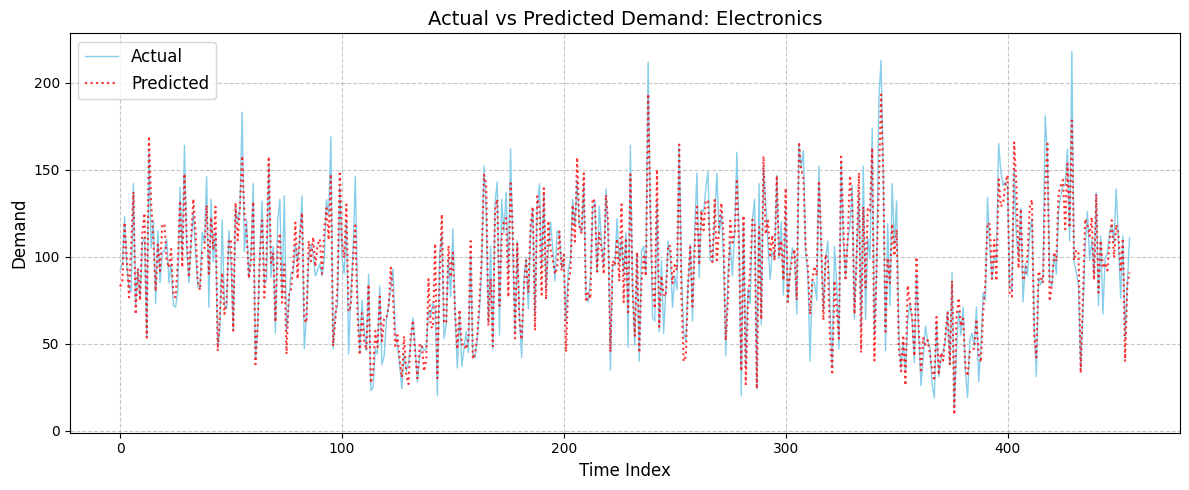

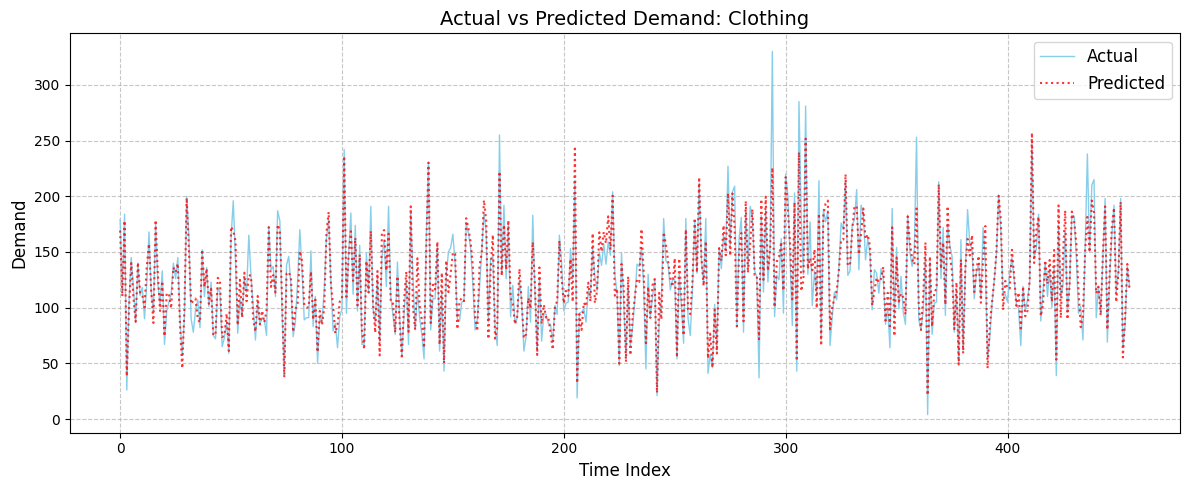

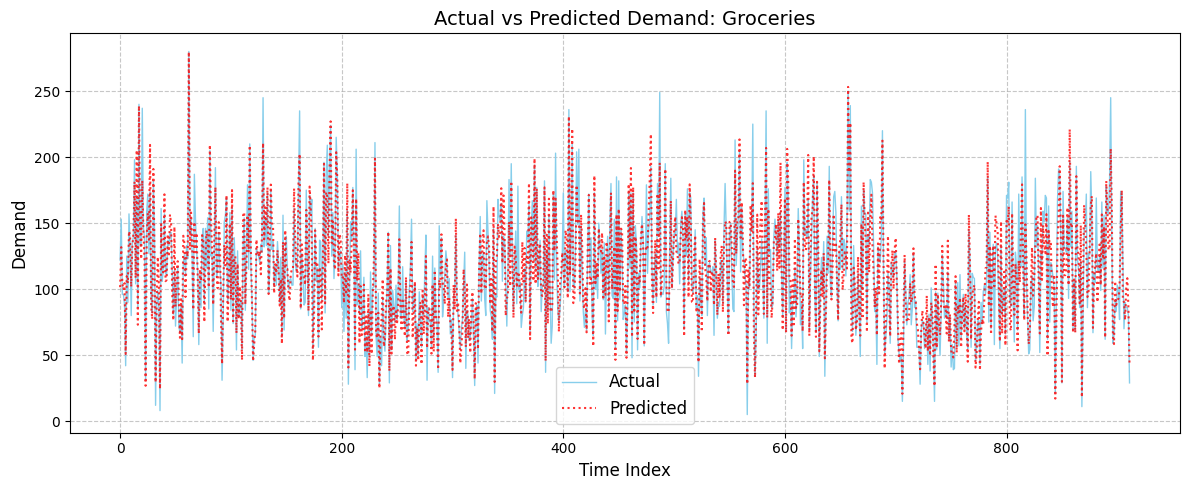

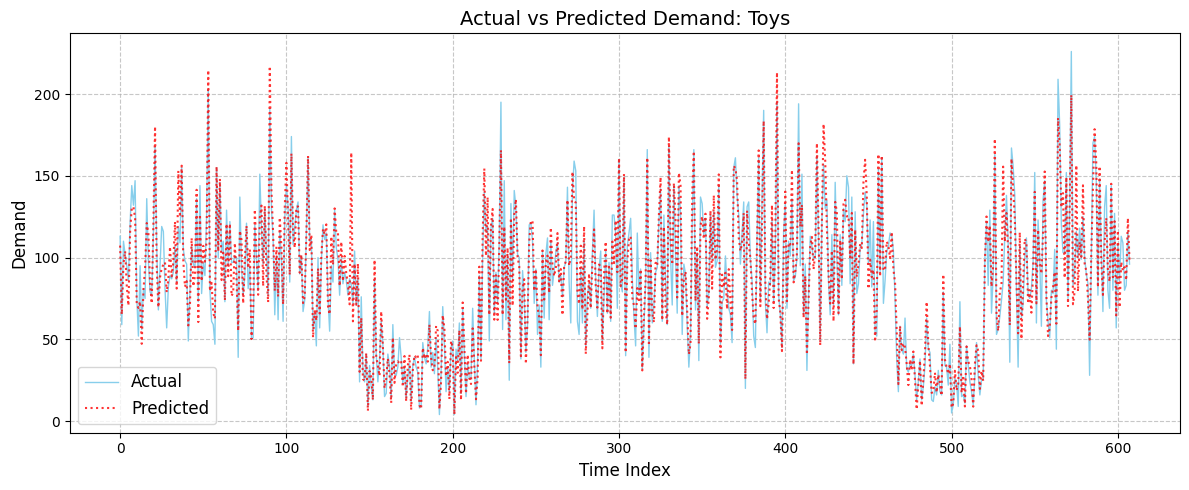

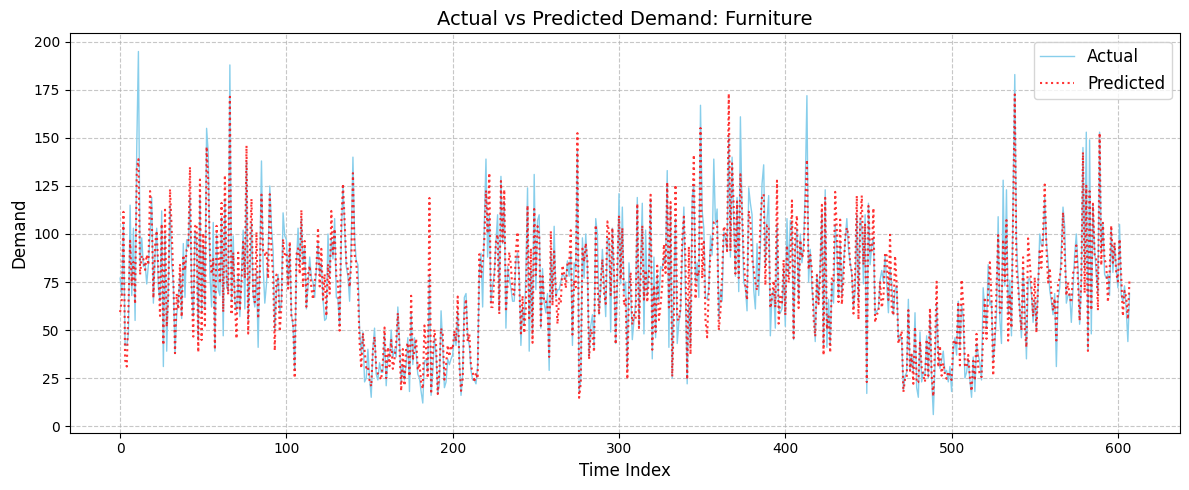

In [100]:
for category in results:
    # Ambil data dari results
    y_test = results[category]['y_test'].reset_index(drop=True)
    y_pred = pd.Series(results[category]['y_pred']).reset_index(drop=True)

    # Buat plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label='Actual', linewidth=1, color='skyblue')
    plt.plot(y_pred, label='Predicted', linestyle='dotted', color='red', alpha=0.8)
    plt.title(f"Actual vs Predicted Demand: {category}", fontsize=14)
    plt.xlabel("Time Index", fontsize=12)
    plt.ylabel("Demand", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## **Hyperparameter Tuning**

**Tujuan**: mencari parameter terbaik untuk meningkatkan generalisasi.

In [101]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Dictionary untuk menyimpan hasil tuning
tuned_models = {}

# Param grid untuk XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Lakukan grid search untuk setiap kategori
for category, data in train_test_data.items():
    X_train = data['X_train']
    y_train = data['y_train']

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,
        verbose=0,
        n_jobs=-1
    )

    print(f"🔧 Tuning model untuk kategori: {category}")
    grid_search.fit(X_train, y_train)

    # Simpan model terbaik
    tuned_models[category] = grid_search.best_estimator_

    print(f"   Best Parameters: {grid_search.best_params_}\n")

tuned_models.keys()

🔧 Tuning model untuk kategori: Electronics
   Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

🔧 Tuning model untuk kategori: Clothing
   Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

🔧 Tuning model untuk kategori: Groceries
   Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

🔧 Tuning model untuk kategori: Toys
   Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

🔧 Tuning model untuk kategori: Furniture
   Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}



dict_keys(['Electronics', 'Clothing', 'Groceries', 'Toys', 'Furniture'])

In [102]:
# Parameter terbaik hasil tuning (masukkan sesuai hasil sebelumnya)
best_params = {
    'Electronics': {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8},
    'Clothing': {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0},
    'Groceries': {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0},
    'Toys': {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0},
    'Furniture': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
}

# Menyimpan model dan evaluasi
trained_models = {}
evaluation_results = []

for category in train_test_data.keys():
    print(f"🧠 Retraining model with tuned parameters: {category}")

    X_train = train_test_data[category]['X_train']
    X_test = train_test_data[category]['X_test']
    y_train = train_test_data[category]['y_train']
    y_test = train_test_data[category]['y_test']

    # Training
    model = XGBRegressor(**best_params[category], random_state=42)
    model.fit(X_train, y_train)

    # Simpan model
    trained_models[category] = model

    # Prediksi
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)

    evaluation_results.append({
        'Category': category,
        'MAE': mae,
        'RMSE': rmse,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'R2_Gap': r2_train - r2_test,
        'y_test': y_test,
        'y_pred': y_pred_test
    })


🧠 Retraining model with tuned parameters: Electronics
🧠 Retraining model with tuned parameters: Clothing
🧠 Retraining model with tuned parameters: Groceries
🧠 Retraining model with tuned parameters: Toys
🧠 Retraining model with tuned parameters: Furniture


In [103]:
# Tampilkan hasil evaluasi dalam DataFrame
eval_df = pd.DataFrame(evaluation_results)
eval_df.set_index('Category', inplace=True)
eval_df = eval_df.round(4)
print("\n📊 Evaluation After Hyperparameter Tuning:")
display(eval_df)


📊 Evaluation After Hyperparameter Tuning:


MAE     RMSE  R2_Train  R2_Test  R2_Gap  \
Category                                                   
Electronics   8.7785  11.5927    0.9995   0.8988  0.1007   
Clothing     10.4674  14.4182    0.9987   0.9000  0.0987   
Groceries    12.2274  15.5474    0.9908   0.8718  0.1190   
Toys          8.8414  11.6773    0.9744   0.9203  0.0541   
Furniture     7.5977   9.9783    0.9806   0.9000  0.0805   

                                                        y_test  \
Category                                                         
Electronics  1824     92
1825     96
1826    123
1827     9...   
Clothing     1824    179
1825    114
1826    184
1827     2...   
Groceries    3648    122
3649    153
3650     96
3651     9...   
Toys         2432    113
2433     59
2434    110
2435    10...   
Furniture    2432     77
2433     68
2434    105
2435     4...   

                                                        y_pred  
Category                                                        
Electronics  [59.341667, 65.92311, 111.5106, 34.411667, 30....  
Clothing     [59.341667, 65.92311, 111.5106, 34.411667, 30....  
Groceries    [59.341667, 65.92311, 111.5106, 34.411667, 30....  
Toys         [59.341667, 65.92311, 111.5106, 34.411667, 30....  
Furniture    [59.341667, 65.92311, 111.5106, 34.411667, 30....

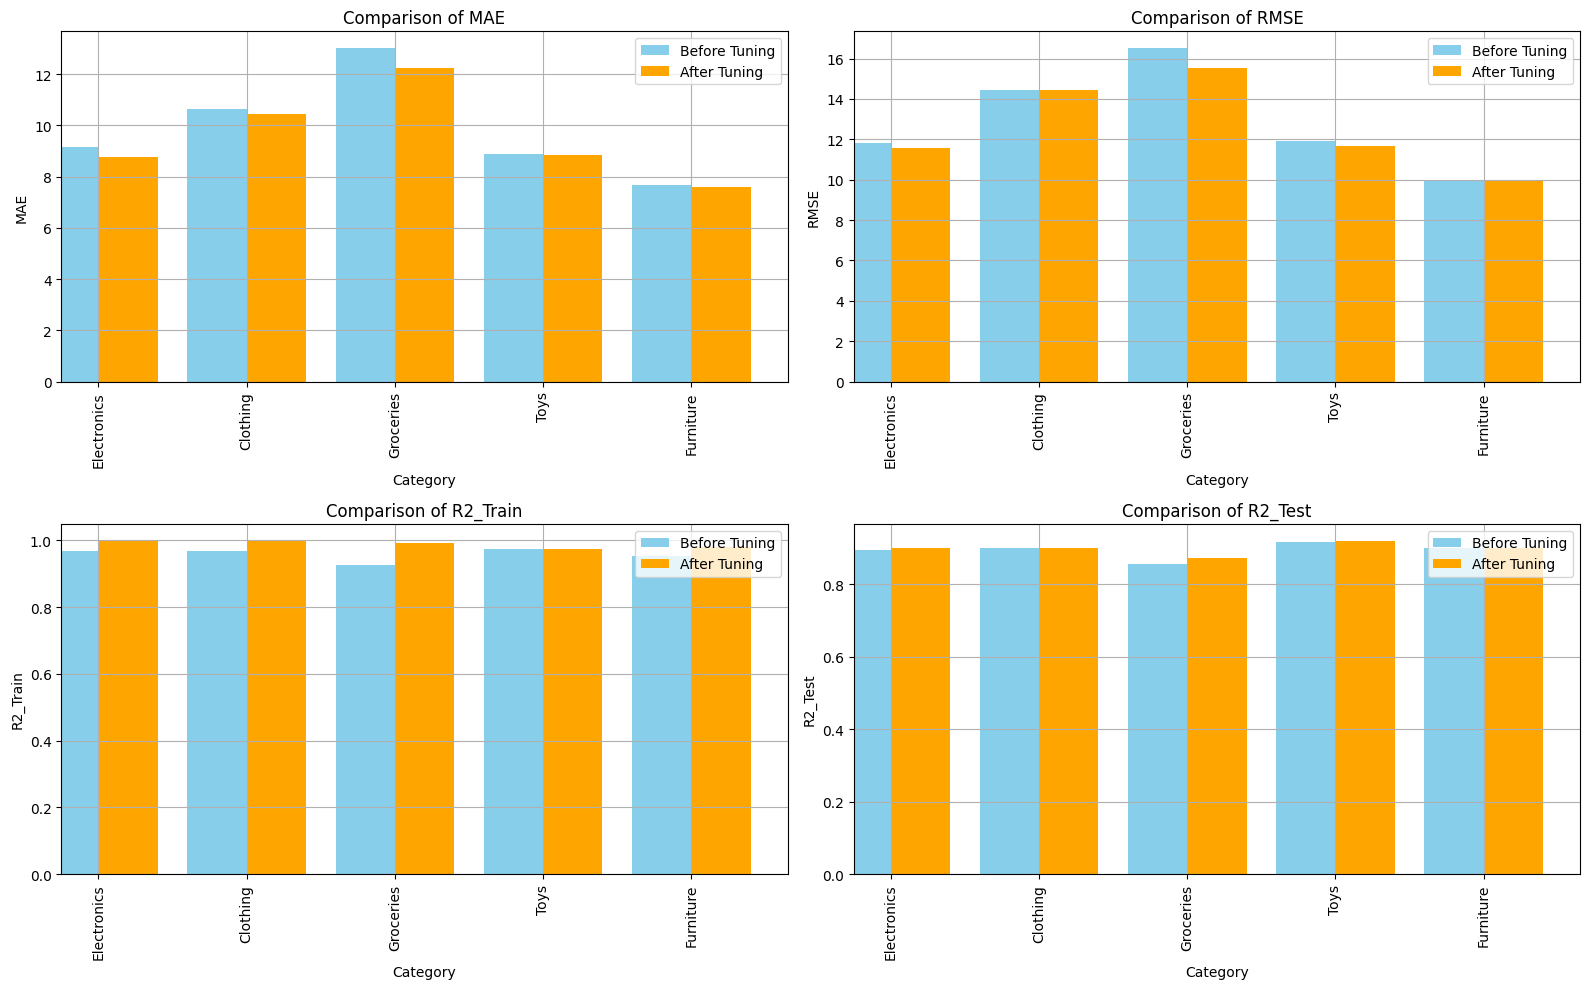

In [111]:
# Data sebelum tuning
results_df = results_df.rename(columns={
    'R² (Train)': 'R2_Train',
    'R² (Test)': 'R2_Test'
})
# Data setelah tuning
## eval_df

# Plotting
metrics = ['MAE', 'RMSE', 'R2_Train', 'R2_Test']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    results_df[metric].plot(kind='bar', ax=ax, color='skyblue', width=0.4, position=1, label='Before Tuning')
    eval_df[metric].plot(kind='bar', ax=ax, color='orange', width=0.4, position=0, label='After Tuning')
    ax.set_title(f'Comparison of {metric}')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()